# OPTaaS: Plotting Results
You can use a library like matplotlib to display a live view of your optimization results.

### Set up matplotlib

In [1]:
%matplotlib inline

## Define your scoring function
For this example we will use the [Ackley function](https://www.sfu.ca/~ssurjano/ackley.html), which is widely used for testing optimization algorithms.

In [2]:
from math import pi
import numpy as np

def ackley_function(x, y):
    a = 20
    b = 0.2
    c = pi * 2
    d = 2

    sum1 = x ** 2 + y ** 2
    sum2 = np.cos(c * x) + np.cos(c * y)

    term1 = a * np.exp(-b * np.sqrt(sum1 / d))
    term2 = np.exp(sum2 / d)

    return -term1 - term2 + a + np.exp(1)

## Connect to the OPTaaS server and create a Task

In [3]:
from mindfoundry.optaas.client.client import OPTaaSClient, Goal
from mindfoundry.optaas.client.parameter import FloatParameter

client = OPTaaSClient('https://optaas.mindfoundry.ai', '<Your OPTaaS API key>')

task = client.create_task(
    title='Ackley Optimization',
    parameters=[
        FloatParameter(name='x', minimum=-32.768, maximum=32.768, default=32.768),
        FloatParameter(name='y', minimum=-32.768, maximum=32.768, default=32.768)
    ], 
    goal=Goal.min
)

## Wrap your scoring function in a Plotting function

In [4]:
from IPython.display import clear_output
import math
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter, MaxNLocator

class Plotter:
    @staticmethod
    def make_plotting_function(task, scoring_function):
        return Plotter(task, scoring_function).get_score_and_display_plot
        
    def __init__(self, task, scoring_function):
        self.scoring_function = scoring_function
        self.current_iteration = 0
        self.all_scores = []
        self.best_scores = []
        self.minimise = task.json.get('goal') == "min"
        self.better_of = min if self.minimise else max
        self.best_score = math.inf if self.minimise else -math.inf        
        self.df = pd.DataFrame(columns=[p['name'] for p in task.parameters] + ['score'])

    def get_score_and_display_plot(self, **configuration_values):
        score = self.scoring_function(**configuration_values)
        
        self._update_scores(score)
        self._update_table(configuration_values, score)
        self._plot_scores()

        display(plt.gcf())
        display(self.df)
        plt.close('all')
        
        self.current_iteration += 1
        return score

    def _update_scores(self, score):
        self.all_scores.append(score)
        self.best_score = self.better_of(self.best_score, score)
        self.best_scores.append(self.best_score)
    
    def _update_table(self, configuration_values, score):
        values_with_score = configuration_values.copy()
        values_with_score['score'] = score
        self.df.loc[self.current_iteration] = values_with_score

    def _plot_scores(self):
        clear_output(wait=True)
        plt.clf()
        
        fig = plt.figure(figsize=(20, 10))
        ax = fig.add_subplot(1, 2, 1)
        
        if self.minimise:
            ax.invert_yaxis()
            ax.yaxis.set_major_formatter(FormatStrFormatter('%d'))
            if all(score >= 0 for score in self.best_scores):
                ax.set_yscale('log')

        ax.set_ylabel('Score')
        ax.xaxis.set_major_locator(MaxNLocator(integer=True))
        ax.set_xlabel('Iterations')

        ax.plot(self.best_scores, 'g', label='Best so far')
        ax.plot(self.all_scores, 'ok')
        ax.legend()

plotting_function = Plotter.make_plotting_function(task, ackley_function)

## Run the Task

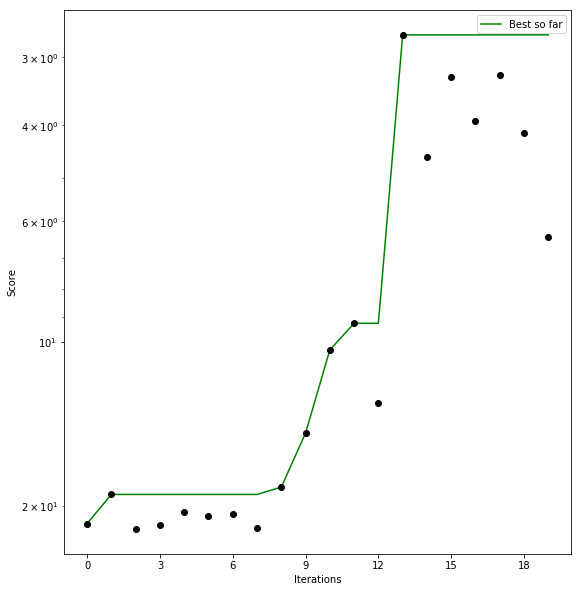

,x,y,score
0,32.768000,32.768000,21.570311
1,-5.689492,-12.767596,19.070211
2,-30.576649,23.701804,22.081071
3,19.588544,-19.718891,21.732203
4,15.171257,18.819132,20.498177
5,23.357021,4.100891,20.923471
6,12.669815,18.904937,20.730211
7,-25.585381,27.751531,21.968379
8,9.872069,-8.362855,18.487494
9,-7.225656,-0.344868,14.713130


Iteration: 19    Score: 6.425530366042068
Configuration: {'x': -0.6077973848037957, 'y': -1.5130208930594526}

Task Completed



({ 'configuration': '8c587fc9-57fc-4660-83d6-8be3c8b9ba56',
   'id': 5280,
   'score': 2.7290226215315703,
   'user_defined_data': None}, { 'id': '8c587fc9-57fc-4660-83d6-8be3c8b9ba56',
   'type': 'exploitation',
   'values': {'x': -0.07391260560005529, 'y': 0.9644407366439016}})

In [5]:
task.run(plotting_function, max_iterations=20)